#👩‍💻 Partie 2 : Préparation des données et configuration de l’environnement

#🟩 Cellule 1 : Vérification et installation de Transformers

In [34]:
try:
  import transformers
except:
  print("Installing transformers")
  !pip -q install transformers


  **🧾 Explication :**
  Cette cellule vérifie si la bibliothèque Transformers est déjà installée.
  Si ce n’est pas le cas, elle l’installe automatiquement avec pip.

#🟩 Cellule 2 : Importation des bibliothèques nécessaires

In [35]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig
from transformers import BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW # Corrected import to use torch.optim.AdamW
from tqdm import tqdm, trange  #for progress bars
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image #for image rendering
import time # Import the time module

**🧾 Explication :**
Ici, on importe toutes les bibliothèques nécessaires :

  **-PyTorch :** pour le calcul et la gestion des tenseurs,

  **-Transformers :** pour le modèle BERT,

  **-pandas/numpy :** pour manipuler les données,

  **-matplotlib :** pour la visualisation,

  **-tqdm :** pour les barres de progression.

# 🟩 Cellule 3 : Activation du GPU

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
!nvidia-smi


Fri Nov  7 06:07:48 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   77C    P0             32W /   70W |    4130MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# 🟩 Cellule 4 : Téléchargement du jeu de données CoLA

In [37]:
import os
!curl -L https://raw.githubusercontent.com/Denis2054/Transformers-for-NLP-2nd-Edition/master/Chapter03/in_domain_train.tsv --output "in_domain_train.tsv"

!curl -L https://raw.githubusercontent.com/Denis2054/Transformers-for-NLP-2nd-Edition/master/Chapter03/out_of_domain_dev.tsv --output "out_of_domain_dev.tsv"


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  428k  100  428k    0     0  1187k      0 --:--:-- --:--:-- --:--:-- 1186k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 28506  100 28506    0     0  81464      0 --:--:-- --:--:-- --:--:-- 81679


# 🟩 Cellule 5 : Chargement du jeu de données

In [38]:
df = pd.read_csv("in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
df.shape


(8551, 4)

# 🟩 Cellule 6 : Aperçu des données

In [39]:
df.sample(10)


,sentence_source,label,label_notes,sentence
1539,r-67,0,*,john is prouder of having gone than nobody exp...
2300,l-93,0,*,that acorn will grow from a seed into an oak t...
1407,r-67,0,*,light was made of her indiscretions .
5741,c_13,1,NaN,the puppy licked the kitten 's face .
5833,c_13,1,NaN,for mary to love that boor is a travesty .
4011,ks08,0,*,john made mary to cook korean food .
468,bc01,1,NaN,he fed the children .
7069,sgww85,1,NaN,either you or i will incriminate ourselves .
7103,sgww85,1,NaN,john did n't give the books to mary and the pa...
4492,ks08,0,*,speaking not english is a disadvantage .


# 🟩 Cellule 7 : Préparation des phrases et des labels

In [40]:
sentences = df.sentence.values
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values


# 🟩 Cellule 8 : Chargement du tokenizer de BERT

In [41]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)


# 🟩 Cellule 9 : Tokenisation des phrases

In [42]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print("Tokenize the first sentence:")
print(tokenized_texts[0])


Tokenize the first sentence:
['[CLS]', 'our', 'friends', 'wo', 'n', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.', '[SEP]']


#🟩 Cellule 10 : Conversion des tokens en identifiants numériques

In [43]:
MAX_LEN = 128
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")


# 🟩 Cellule 11 : Création des masques d’attention

In [44]:
attention_masks = []
for seq in input_ids:
    seq_mask = [float(i > 0) for i in seq]
    attention_masks.append(seq_mask)


# 🟩 Cellule 12 : Division en ensembles d’entraînement et de validation

In [45]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels,
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=2018, test_size=0.1)


# 🟩 Cellule 12 : Division en ensembles d’entraînement et de validation

In [46]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)


# 🟩 Cellule 14 : Création des DataLoaders

In [47]:
batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


# 👨‍💻 Partie 3 : Entraînement, Évaluation et Résultats

In [48]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.cuda()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

# 🟩 Cellule 1 : Chargement du modèle BERT pour la classification

In [49]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.cuda()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

# 🟩 Cellule 2 : Définition de l’optimiseur

In [50]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)


# 🟩 Cellule 3 : Planification du taux d’apprentissage

In [51]:
epochs = 4
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)


# 🟩 Cellule 4 : Fonction d’évaluation du modèle

In [52]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


# 🟩 Cellule 5 : Boucle d’entraînement

In [53]:
train_loss_set = []
for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        if step % 40 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()

        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        labels=b_labels)
        loss = outputs.loss
        train_loss_set.append(loss.item())
        total_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)

        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(format(time.time() - t0)))



======== Epoch 1 / 4 ========
Training...
  Batch    40  of    241.
  Batch    80  of    241.
  Batch   120  of    241.
  Batch   160  of    241.
  Batch   200  of    241.
  Batch   240  of    241.

  Average training loss: 0.51
  Training epoch took: 145.7837827205658

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    241.
  Batch    80  of    241.
  Batch   120  of    241.
  Batch   160  of    241.
  Batch   200  of    241.
  Batch   240  of    241.

  Average training loss: 0.32
  Training epoch took: 145.74828147888184

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    241.
  Batch    80  of    241.
  Batch   120  of    241.
  Batch   160  of    241.
  Batch   200  of    241.
  Batch   240  of    241.

  Average training loss: 0.19
  Training epoch took: 145.51980805397034

======== Epoch 4 / 4 ========
Training...
  Batch    40  of    241.
  Batch    80  of    241.
  Batch   120  of    241.
  Batch   160  of    241.
  Batch   200  of    241.
  Batch   24

# 🟩 Cellule 6 : Courbe de perte d’entraînement

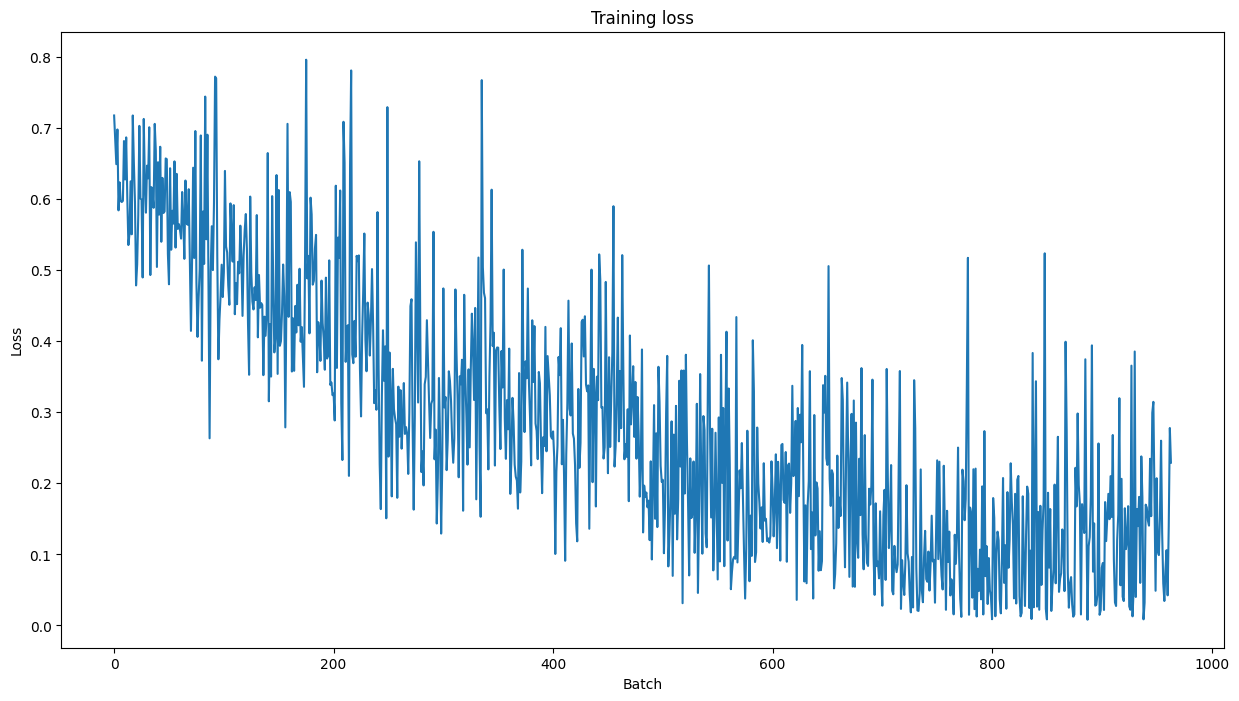

In [54]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()


# 🟩 Cellule 7 : Évaluation du modèle

In [55]:
print("Running Validation...")
model.eval()
eval_accuracy = 0
nb_eval_steps = 0

for batch in validation_dataloader:
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    with torch.no_grad():
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask)

    logits = outputs.logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)

    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

print("Validation Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))


Running Validation...
Validation Accuracy: 0.82


# 🟩 Cellule 8 : Résultats finaux

In [56]:
print("Training complete!")


Training complete!


# 🟩 Cellule 9 : Enregistrement du modèle fine-tunig

In [57]:
import os

# Créer un dossier pour sauvegarder le modèle
output_dir = '/content/drive/MyDrive/model_save/'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Sauvegarde du modèle et du tokenizer
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)


Saving model to /content/drive/MyDrive/model_save/


('/content/drive/MyDrive/model_save/tokenizer_config.json',
 '/content/drive/MyDrive/model_save/special_tokens_map.json',
 '/content/drive/MyDrive/model_save/vocab.txt',
 '/content/drive/MyDrive/model_save/added_tokens.json')